### Imports

In [1]:
import pandas as pd
import numpy as np
import torch as th
from torch.utils.data import DataLoader, TensorDataset, Dataset
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import lightning as L
import seaborn as sns
# from torchsummary import summary
from torchinfo import summary
## Settings
plt.rcParams['figure.figsize'] = [20, 7]
from tqdm.notebook import tqdm
tqdm.pandas()

### Preliminary Analysis

In [2]:
df = pd.read_csv("../data/Electricity_production.csv")
# df.index.freq = 'MS'

In [3]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
df.shape

(397, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [6]:
df = (
    df
    .assign(date=lambda x: pd.to_datetime(x["DATE"]))
    .assign(month=lambda x: x["date"].dt.month,
            year=lambda x: x["date"].dt.year)
    .set_index("date")
    .drop("DATE", axis=1)
    .rename(columns={"IPG2211A2N":"production"})
)
df.head()

,production,month,year
date,,,
1985-01-01,72.5052,1,1985
1985-02-01,70.6720,2,1985
1985-03-01,62.4502,3,1985
1985-04-01,57.4714,4,1985
1985-05-01,55.3151,5,1985


<Axes: xlabel='date'>

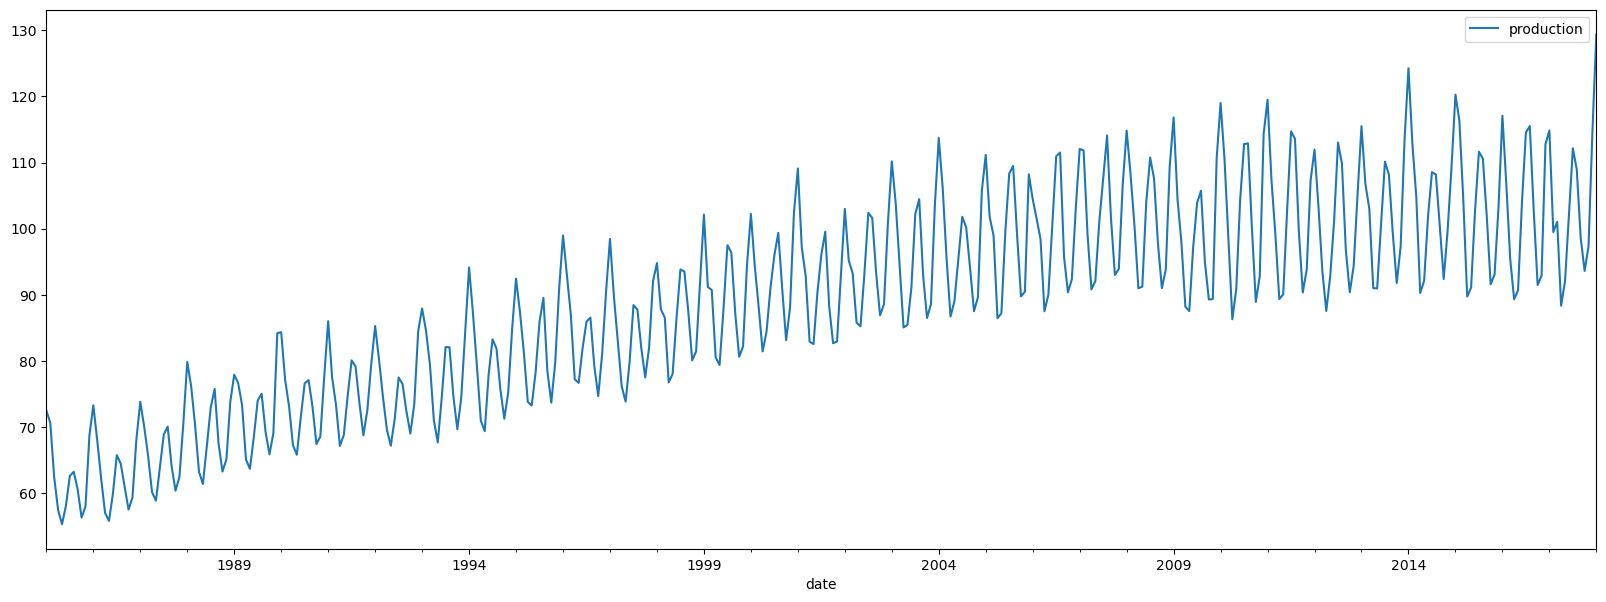

In [7]:
df.plot(y="production")

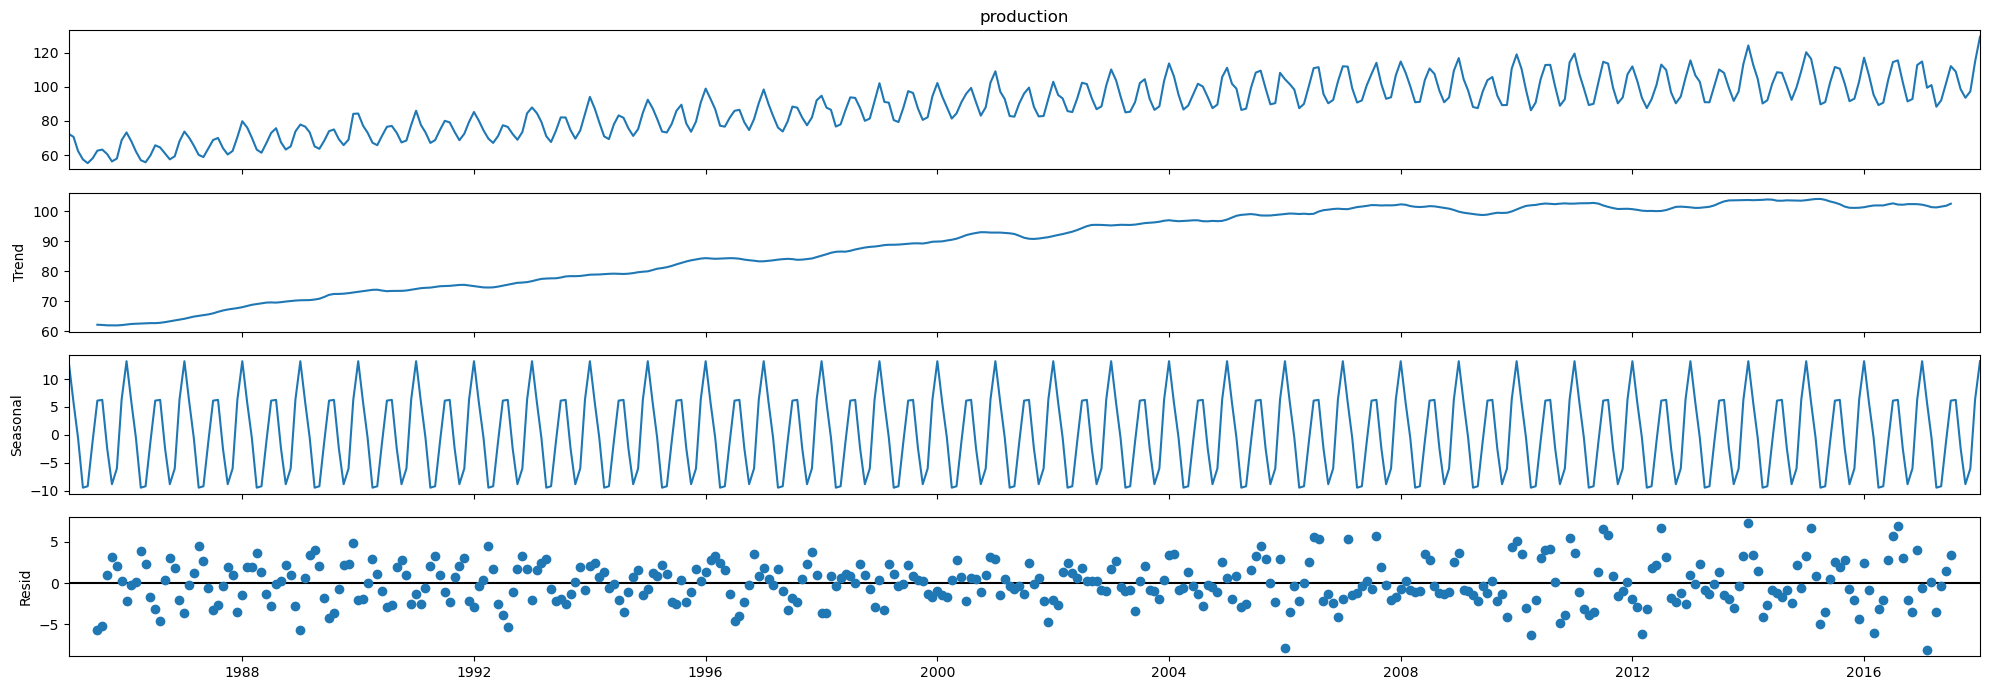

In [8]:
results = seasonal_decompose(df['production'])
results.plot()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

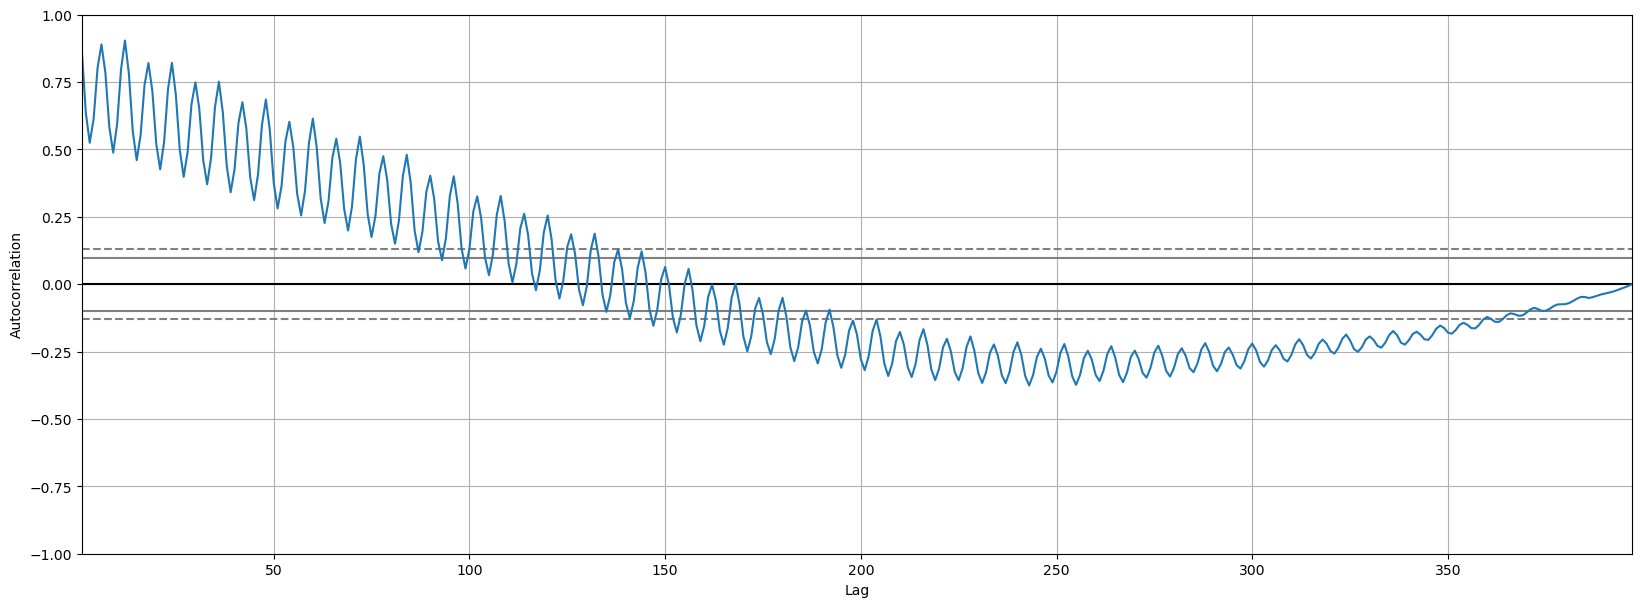

In [9]:
pd.plotting.autocorrelation_plot(df['production'])

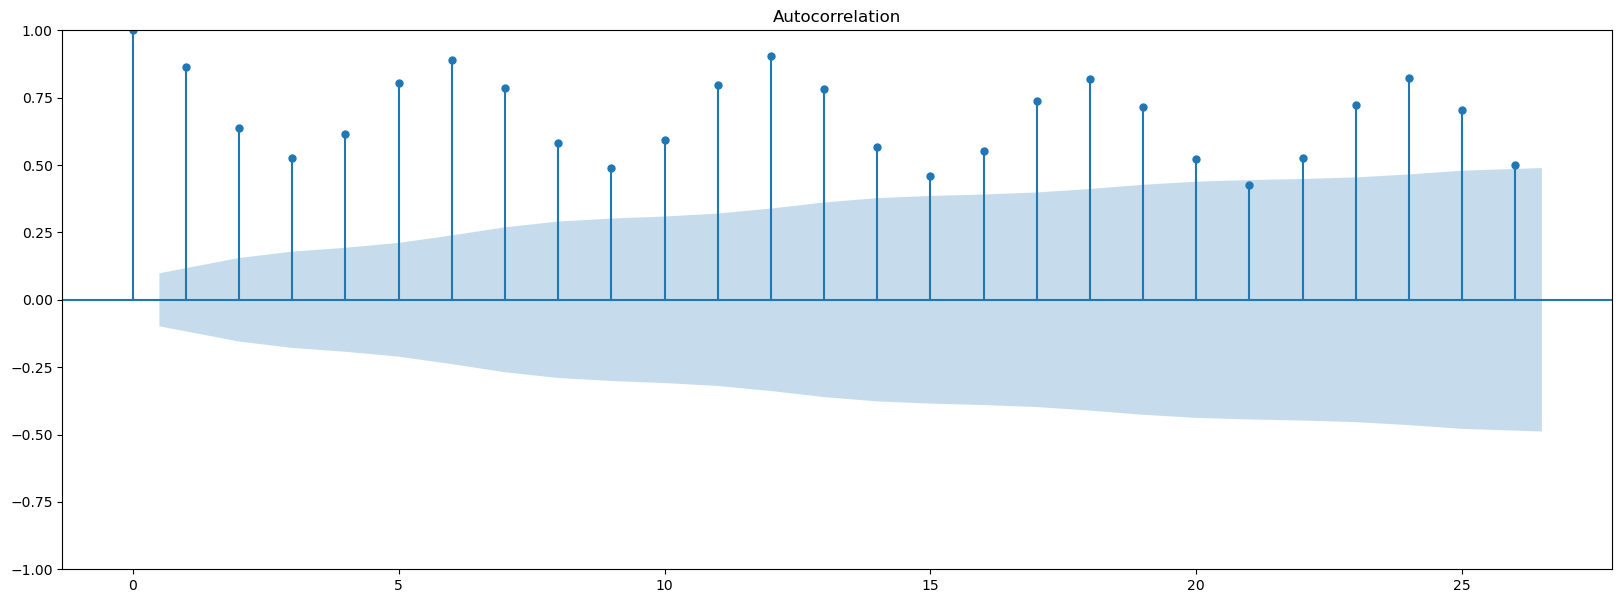

In [10]:
plot_acf(df['production'])
plt.show()

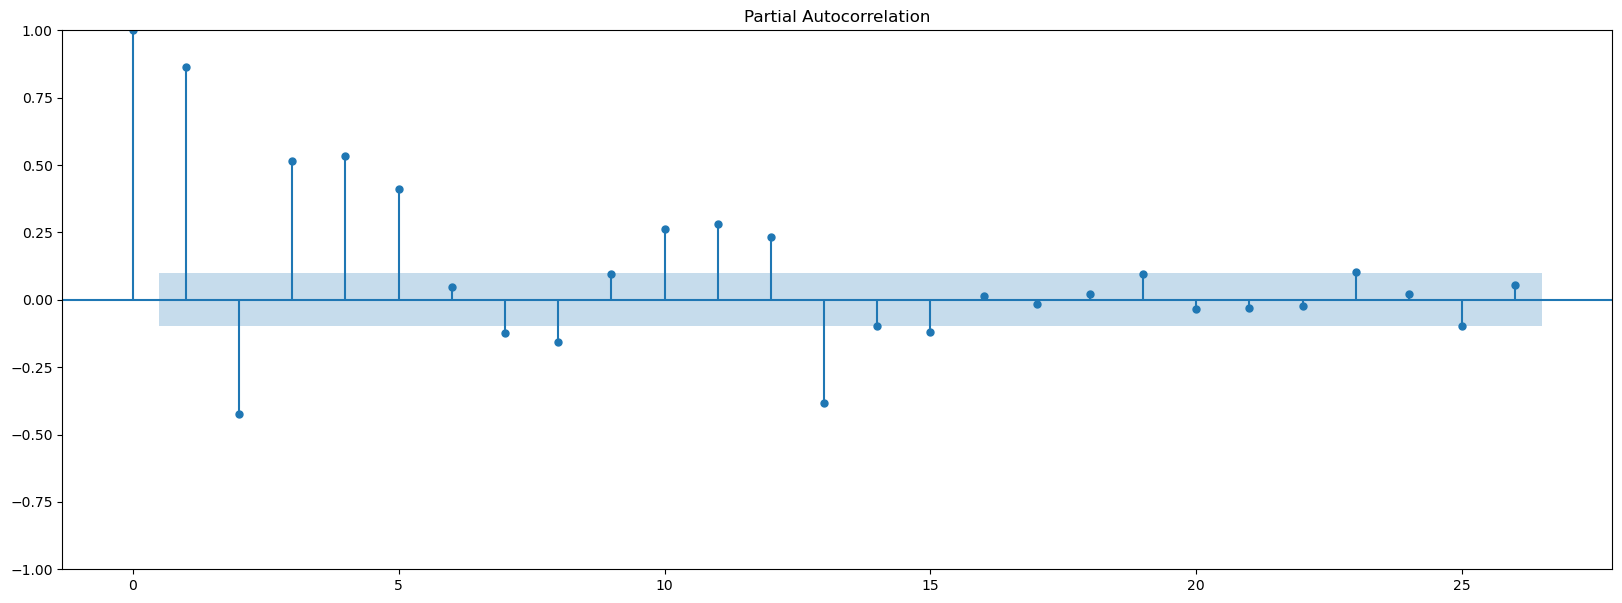

In [11]:
plot_pacf(df['production'])
plt.show()

### Data Prep

In [12]:
test_indices = 100
train_indices = df.shape[0]- test_indices
train_indices, test_indices

(297, 100)

In [13]:
train = df['production'].values[:train_indices]
val = df['production'].values[train_indices:train_indices+50]
test = df['production'].values[train_indices+50:]
train.shape, val.shape, test.shape

((297,), (50,), (50,))

In [14]:
scaler = MinMaxScaler()
scaler.fit(train.reshape(-1, 1))

MinMaxScaler()

In [15]:
scaler.data_max_

array([116.8316])

In [16]:
scaler.data_min_

array([55.3151])

In [17]:
train.shape

(297,)

In [18]:
train = scaler.transform(train.reshape(-1, 1))
val = scaler.transform(val.reshape(-1, 1))
test = scaler.transform(test.reshape(-1, 1))

In [19]:
train.shape

(297, 1)

### Pytorch Dataset and DataModule

In [20]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x: np.ndarray , sequence_length: int, device: str="cpu"):
        self.x = x
        self.sequence_length = sequence_length
        self.device=device

    def __len__(self):
        return len(self.x) - (self.sequence_length)
        
    def __getitem__(self, idx):
        return (th.Tensor(self.x[idx: idx+self.sequence_length]), th.Tensor(self.x[idx+self.sequence_length]))

In [22]:
class ElectricityDataModule(L.LightningDataModule):
    def __init__(self, 
                 train_sequences: np.ndarray, 
                 test_sequences:np.ndarray, 
                 val_sequences: np.ndarray,
                 sequence_length: int, 
                 batch_size: int=10):
        super().__init__()
        self.train_sequences    =   train_sequences
        self.test_sequences     =   test_sequences
        self.val_sequences      =   val_sequences
        self.sequence_length    =   sequence_length
        self.batch_size         =   batch_size
        
    def setup(self, stage=None):
        self.train_dataset  =   TimeSeriesDataset(self.train_sequences, self.sequence_length)
        self.val_dataset    =   TimeSeriesDataset(self.val_sequences, self.sequence_length)
        self.test_dataset   =   TimeSeriesDataset(self.test_sequences, self.sequence_length)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

### Pytorch Model

In [23]:
# Creating the LSTM model
class LSTMModel(L.LightningModule):
    def __init__(self, n_features, n_hidden=128, n_layers=2, lr=1e-3, dropout=0.2):
        super().__init__()
        self.n_hidden = n_hidden
        self.lstm = th.nn.LSTM(input_size = n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.output_layer = th.nn.Linear(n_hidden, 1)
        self.layer_norm = th.nn.LayerNorm(n_hidden)
        self.loss = th.nn.MSELoss()
        self.learning_rate = lr

    def forward(self, x):
        # self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(x)
        lstm_out_ = self.layer_norm(lstm_out[:, -1])
        output = self.output_layer(lstm_out_)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        # print(x.shape)
        output = self(x)
        loss = F.mse_loss(output, y)
        self.log(f"train_loss", loss, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x_hat = self(x)
        test_loss = F.mse_loss(x_hat, y)
        self.log("test_loss", test_loss, logger=True)
    
    def validation_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x_hat = self(x)
        test_loss = F.mse_loss(x_hat, y)
        self.log("validation_loss", test_loss, logger=True)

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        optimiser = th.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimiser

### Training & Testing

In [24]:
## BEST TRAINING PARAMS
N_EPOCHS = 500
BATCH_SIZE = 8
SEQUENCE_LENGTH = 5
N_HIDDEN = 32
N_LAYERS = 1
LR=1e-4

In [25]:
data_module = ElectricityDataModule(train_sequences=train, test_sequences=test,val_sequences=val, sequence_length=SEQUENCE_LENGTH, batch_size=BATCH_SIZE)
data_module.setup()

In [26]:
model = LSTMModel(n_features=1, n_hidden=N_HIDDEN, n_layers=N_LAYERS, lr=LR)
print(model)

LSTMModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (loss): MSELoss()
)


In [27]:
summary(model, input_size=(1,5,1))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 1]                    --
├─LSTM: 1-1                              [1, 5, 32]                4,480
├─LayerNorm: 1-2                         [1, 32]                   64
├─Linear: 1-3                            [1, 1]                    33
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [28]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs/

In [29]:
checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpont",
    save_top_k=1,
    # verbose=True,
    monitor="validation_loss",
    mode="min"
)
logger = L.pytorch.loggers.tensorboard.TensorBoardLogger(
    "lightning_logs",
    name="electricity-prediction"
)

early_stopping_callbacks = L.pytorch.callbacks.EarlyStopping(
    monitor="train_loss",
    patience=5
)

trainer = L.Trainer(
    logger=logger,
    callbacks=[early_stopping_callbacks, checkpoint_callback],
    max_epochs=N_EPOCHS,
    # enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model=model, datamodule=data_module)

Missing logger folder: lightning_logs/electricity-prediction
/home/parth/anaconda3/envs/dl/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/parth/repo/TimeSeries/notebook/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type      | Params
-------------------------------------------
0 | lstm         | LSTM      | 4.5 K 
1 | output_layer | Linear    | 33    
2 | layer_norm   | LayerNorm | 64    
3 | loss         | MSELoss   | 0     
-------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/parth/anaconda3/envs/dl/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [31]:
trainer.test(model=model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.007127637509256601
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.007127637509256601}]

In [32]:
trainer.validate(model=model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss       0.004178892355412245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 0.004178892355412245}]

In [33]:
prediction = trainer.predict(model=model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [34]:
final = []
for temp in prediction:
    final.extend(temp.reshape(1, -1).squeeze(0).tolist())
final_scaled_prediction = scaler.inverse_transform(np.fromiter(final, dtype=np.float32).reshape(-1, 1))

# scaler.inverse_transform(test).shape
actual_final = []
for ele in data_module.predict_dataloader():
    actual_final.extend(ele[1].squeeze(1).tolist())

actual_final = np.fromiter(actual_final, dtype=np.float32)
actual_final = scaler.inverse_transform(actual_final.reshape(-1, 1))
actual_final = actual_final.squeeze(1).tolist()
final_scaled_prediction = final_scaled_prediction.squeeze(1).tolist()
temp = pd.DataFrame(zip(actual_final, final_scaled_prediction), columns=["test", "y_pred"])

#### Output

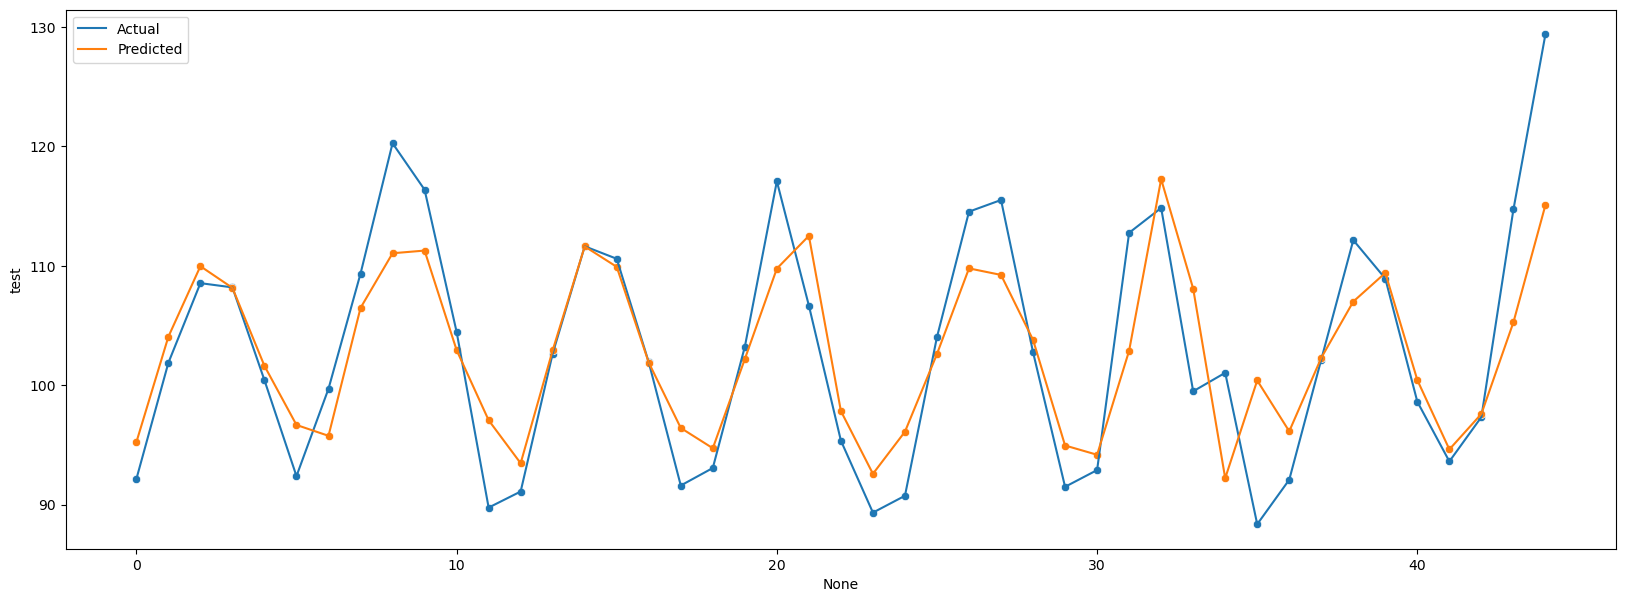

In [35]:
_, ax = plt.subplots(1, 1)
sns.lineplot( data=temp, y="test", x=temp.index, ax=ax, label="Actual")
sns.scatterplot( data=temp, y="test", x=temp.index, ax=ax)
sns.lineplot( data=temp, y="y_pred", x=temp.index, ax=ax, label="Predicted")
sns.scatterplot( data=temp, y="y_pred", x=temp.index, ax=ax)
plt.show()

In [36]:
model.eval()
onnx_program = th.onnx.export(
    model, 
    th.zeros(1, 5, 1),
    "../model/TimeSeries_LSTM.onnx",
    export_params=True
)

/home/parth/anaconda3/envs/dl/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:4662: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


![alt text][def]

[def]: ../data/TimeSeries_LSTM.onnx.png "Title1"